# 1. Exploratory Data Analysis
1.	Which 3 features have the highest number of missing values?
2.	How the price behave over the years?
3.	Plot the the feature distribution using histograms
4.	Compute and order the features by their correlation with label
5.	Add more EDA that will help you understand the data and support your modeling decisions

In [15]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px

In [16]:
# Load Datasets
test_data = pd.read_csv("test.csv", index_col="Id")
train_data = pd.read_csv("train.csv", index_col="Id")

In [17]:
train_data["MSSubClass"] = train_data["MSSubClass"].astype("category")
test_data["MSSubClass"] = test_data["MSSubClass"].astype("category")

In [18]:
# Obtain target and features from training set
target = "SalePrice"
all_features = train_data.drop(columns="SalePrice").columns
continuous_features = train_data.drop(columns="SalePrice").select_dtypes(include="number").columns
categorical_features = train_data.drop(columns="SalePrice").select_dtypes(exclude="number").columns

In [19]:
train_data[target].shape

(1460,)

In [20]:
train_data[all_features].shape

(1460, 79)

In [21]:
train_data[categorical_features].shape

(1460, 44)

In [22]:
train_data[continuous_features].shape

(1460, 35)

## 1. Which 3 features have the highest number of missing values? 
- PoolQC, MiscFeature and Alley are the features with the highest number of missing values

In [23]:
nan_counts = train_data[all_features].isna().agg(["sum", "mean"]).T.rename(columns={"sum": "N", "mean": "%"})
nan_counts = nan_counts.loc[nan_counts["N"] > 0].sort_values("N", ascending=False)
nan_counts.style.format({"N": "{:.0f}", "%": "{:.1%}"})


,N,%
PoolQC,1453,99.5%
MiscFeature,1406,96.3%
Alley,1369,93.8%
Fence,1179,80.8%
FireplaceQu,690,47.3%
LotFrontage,259,17.7%
GarageType,81,5.5%
GarageYrBlt,81,5.5%
GarageFinish,81,5.5%
GarageQual,81,5.5%


In [24]:
# Fill NaNs were appropriate.
categorical_fill_None = [
    "PoolQC", 
    "MiscFeature", 
    "Alley", 
    "Fence", 
    "FireplaceQu", 
    "GarageType", 
    "GarageFinish", 
    "GarageQual", 
    "GarageCond", 
    "BsmtExposure", 
    "BsmtFinType2", 
    "BsmtFinType1", 
    "BsmtCond", 
    "BsmtQual", 
    "MasVnrType",
    "Electrical",
]
train_data[categorical_fill_None] = train_data[categorical_fill_None].fillna("None")

continuous_fill_0 = [
    "LotFrontage", 
    "MasVnrArea", 
]
train_data[continuous_fill_0] = train_data[continuous_fill_0].fillna(0)

In [25]:
nan_counts = train_data[all_features].isna().agg(["sum", "mean"]).T.rename(columns={"sum": "N", "mean": "%"})
nan_counts = nan_counts.loc[nan_counts["N"] > 0].sort_values("N", ascending=False)
nan_counts.style.format({"N": "{:.0f}", "%": "{:.1%}"})

,N,%
GarageYrBlt,81,5.5%


## 2.	How the housing prices behave over the years?
- Mean sale price was $180,922 (SD=$79,442)
- Median sale price $163,000 (IQR: $129,975-$214,000)
- Minimum and maximum sale price were $34,900 and $755,000, respectively
- Boxplot and histogram indicate a rightly skewed distribution of housing sale prices, with outliers

In [26]:
train_data[target].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
SalePrice,1460.0,180921.19589,79442.502883,34900.0,129975.0,163000.0,214000.0,755000.0


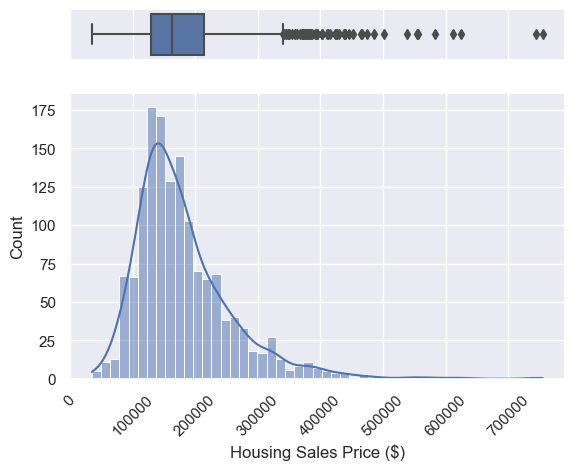

In [27]:
sns.set(style="darkgrid")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=train_data[target], ax=ax_box)
sns.histplot(data=train_data[target], kde=True, ax=ax_hist)
plt.xlabel("Housing Sales Price ($)")
plt.xticks(rotation=45)
ax_box.set(xlabel='')
plt.show()

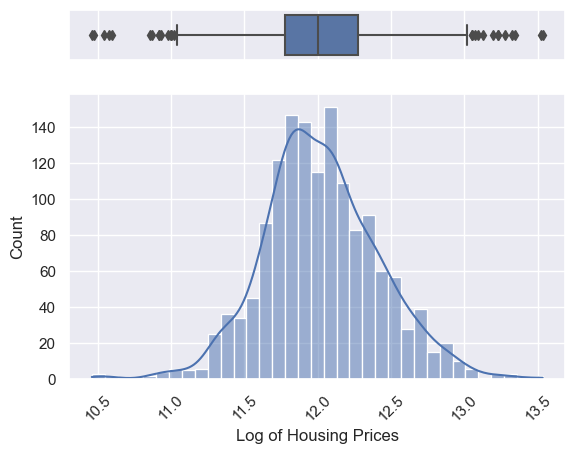

In [28]:
# log of target
sns.set(style="darkgrid")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=np.log(train_data[target]), ax=ax_box)
sns.histplot(data=np.log(train_data[target]), kde=True, ax=ax_hist)
plt.xlabel("Log of Housing Prices")
plt.xticks(rotation=45)
ax_box.set(xlabel='')
plt.show()

In [29]:
# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
prices_over_time = pd.DataFrame()
prices_over_time["Sale Price"] = train_data["SalePrice"].copy()
prices_over_time["Date Sold"] = pd.to_datetime(train_data['MoSold'].astype(str) + '/' + train_data['YrSold'].astype(str), format="%m/%Y")

In [30]:
# plotly https://plotly.com/python/linear-fits/#moving-averages
fig = px.scatter(prices_over_time, x='Date Sold', y="Sale Price", trendline="ols", 
    width=1000,
    height=500,
    title="Scatterplot of Housing Prices Over Time with OLS Trendline")
fig.show()

In [31]:
fig = px.scatter(prices_over_time, x='Date Sold', y="Sale Price", trendline="rolling",
    trendline_options=dict(function="median", window=180),
    width=1000,
    height=500,
    title="Scatterplot of Housing Prices Over Time with Rolling Median Trendline")
fig.show()

In [32]:
def pct25(s):
    return s.quantile(0.25)
def pct75(s):
    return s.quantile(0.75)

price_stats = prices_over_time.resample("M", on="Date Sold")["Sale Price"].agg(["count", "mean", "std", "min", pct25, "median", pct75, "max"])
price_stats.rename(columns={"pct25": "25%", "pct75": "75%"}, inplace=True)

In [33]:
def format_dateoffset_index_year_month(df):
    df = df.copy()
    df.index = df.index.to_series().dt.strftime("%b %Y")
    return df

format_dateoffset_index_year_month(price_stats).style.format("$ {:.0f}", subset=price_stats.columns.drop("count"))

,count,mean,std,min,25%,median,75%,max
Date Sold,,,,,,,,
Jan 2006,10,$ 201090,$ 90281,$ 105000,$ 147500,$ 176700,$ 222250,$ 423000
Feb 2006,9,$ 194322,$ 34660,$ 140000,$ 173000,$ 192500,$ 229000,$ 230000
Mar 2006,25,$ 184982,$ 74230,$ 52500,$ 142500,$ 162900,$ 217500,$ 369900
Apr 2006,27,$ 174313,$ 82495,$ 79000,$ 115000,$ 145250,$ 209195,$ 437154
May 2006,38,$ 158928,$ 49109,$ 81000,$ 130625,$ 156950,$ 179610,$ 312500
Jun 2006,48,$ 172283,$ 76653,$ 79900,$ 119875,$ 151200,$ 207500,$ 475000
Jul 2006,67,$ 183211,$ 90149,$ 80500,$ 135350,$ 160000,$ 196950,$ 625000
Aug 2006,23,$ 196240,$ 77400,$ 85500,$ 127300,$ 196500,$ 245000,$ 374000
Sep 2006,15,$ 223769,$ 102071,$ 107000,$ 146750,$ 202500,$ 291862,$ 465000


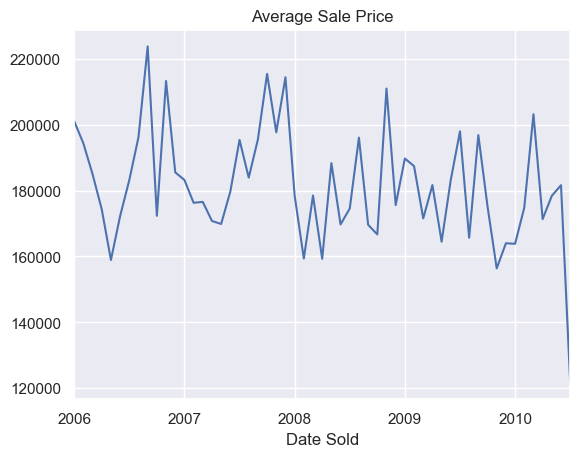

In [34]:
price_stats["mean"].plot()
plt.title("Average Sale Price")
plt.show()

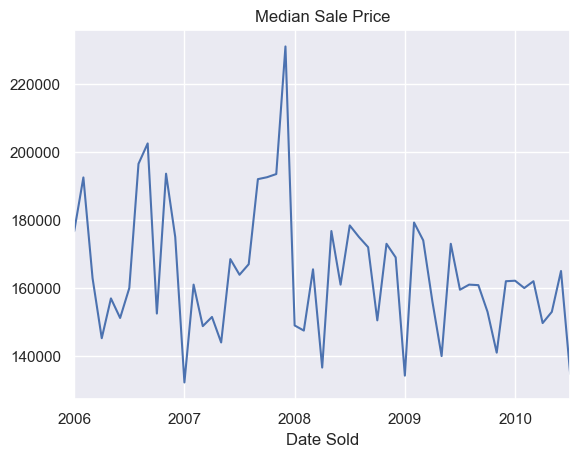

In [35]:
price_stats["median"].plot()
plt.title("Median Sale Price")
plt.show()

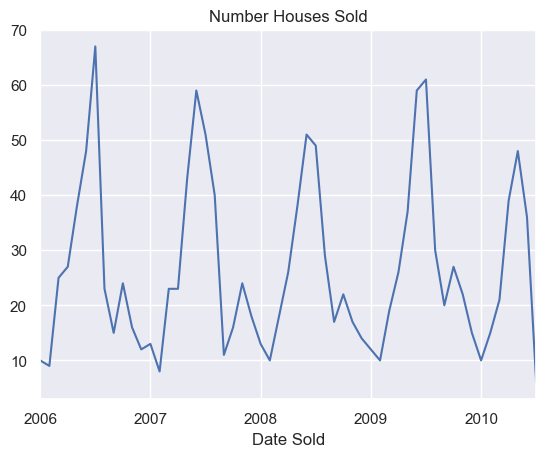

In [36]:
price_stats["count"].plot()
plt.title("Number Houses Sold")
plt.show()

## 3.	Plot the the feature distributions

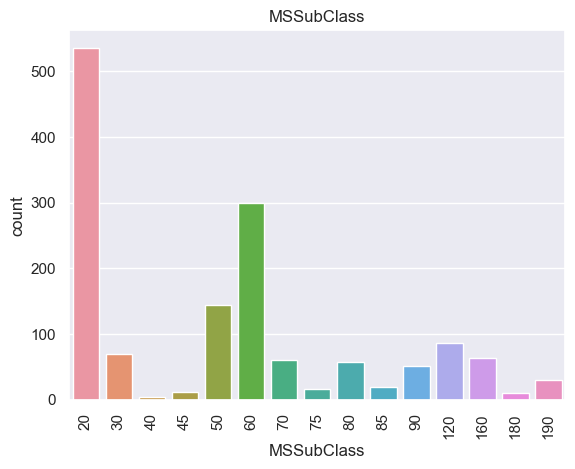

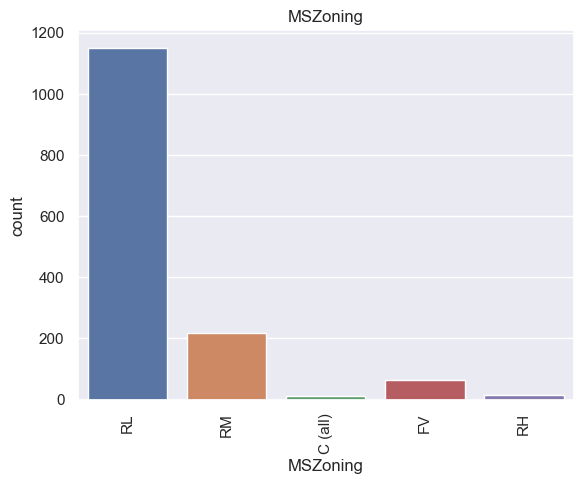

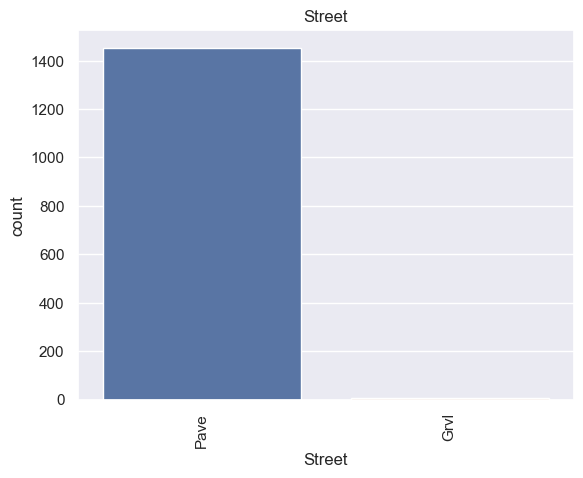

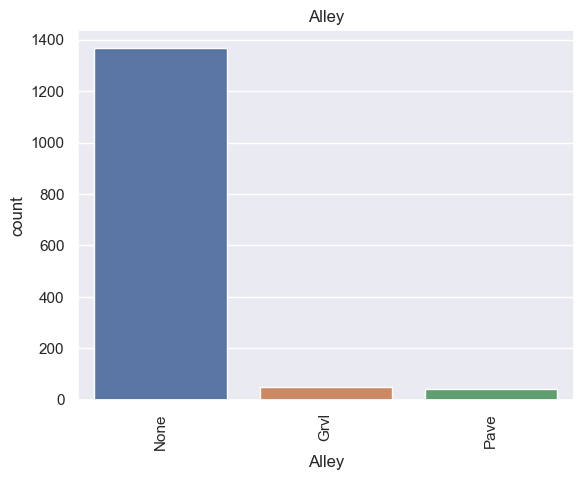

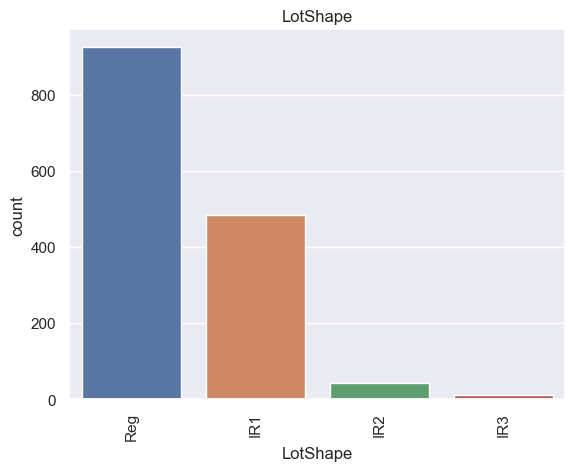

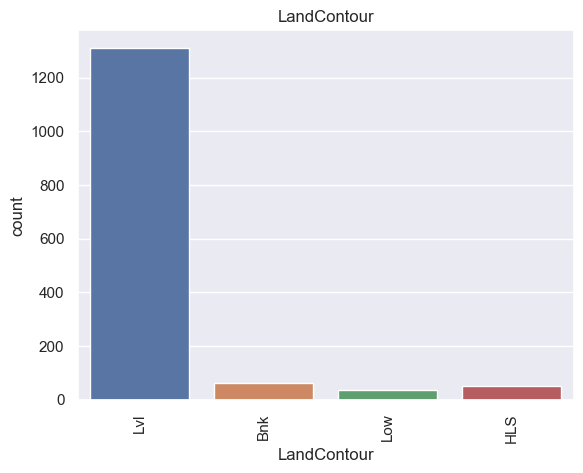

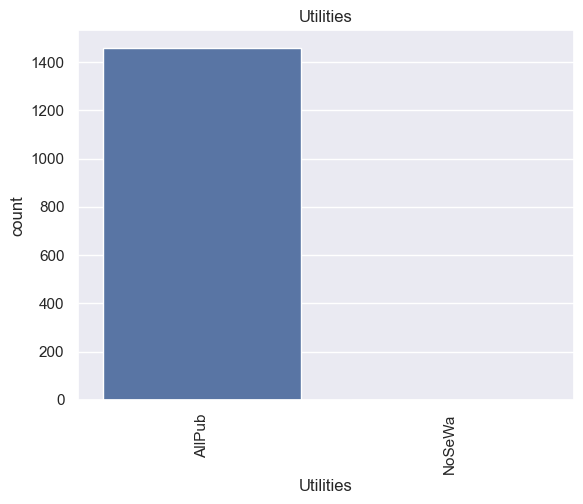

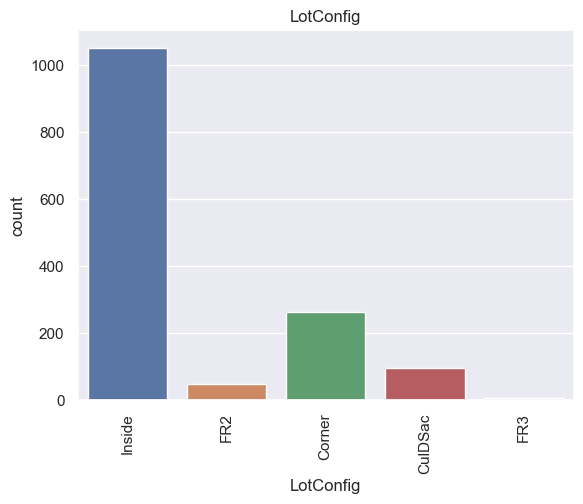

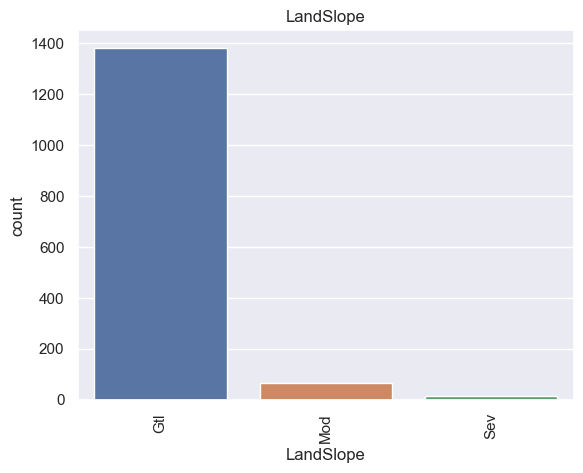

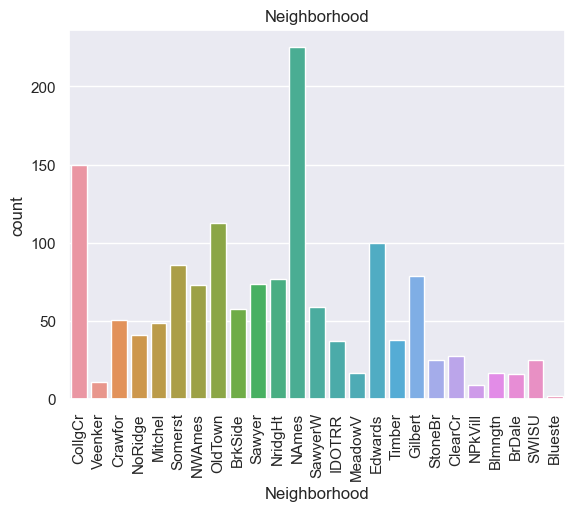

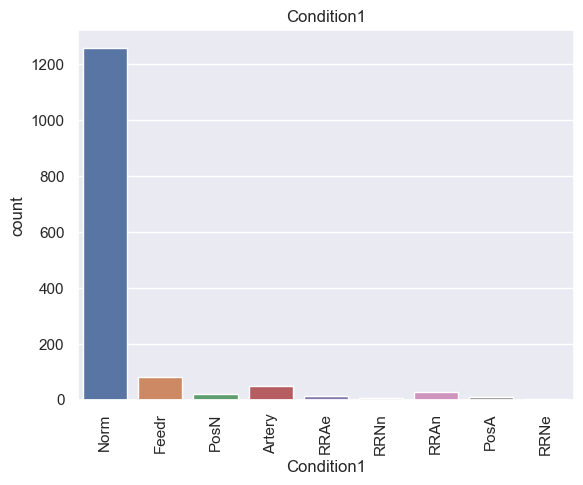

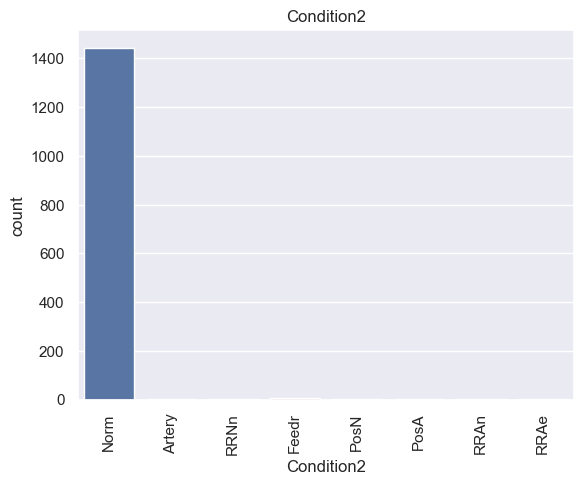

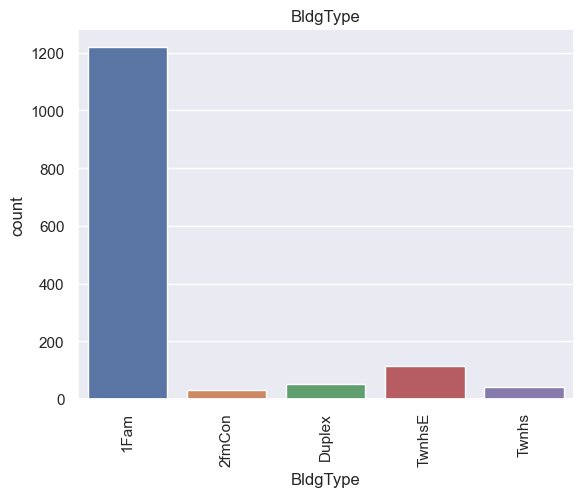

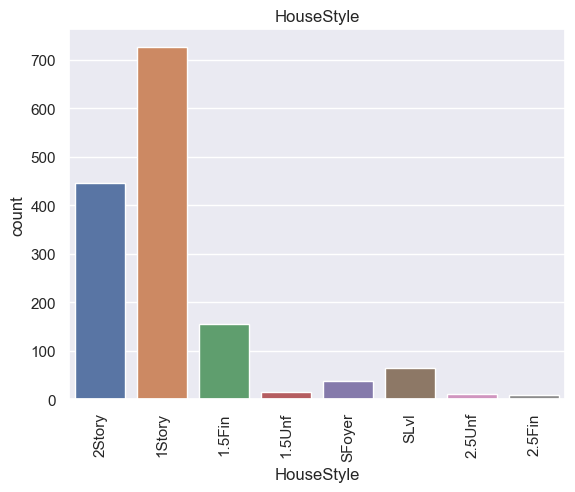

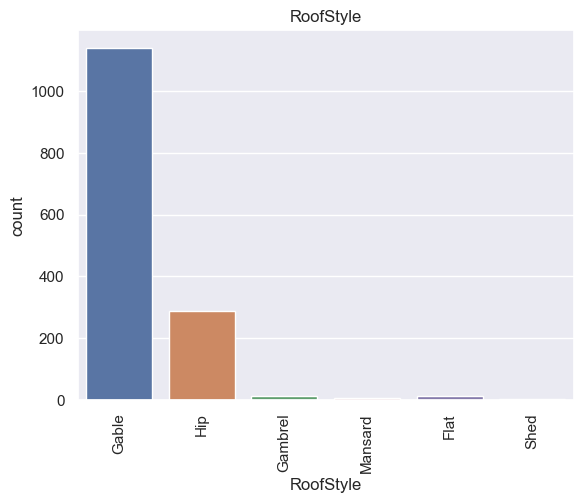

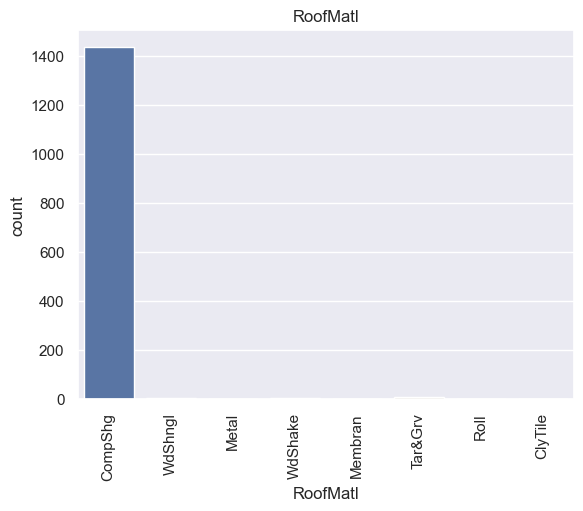

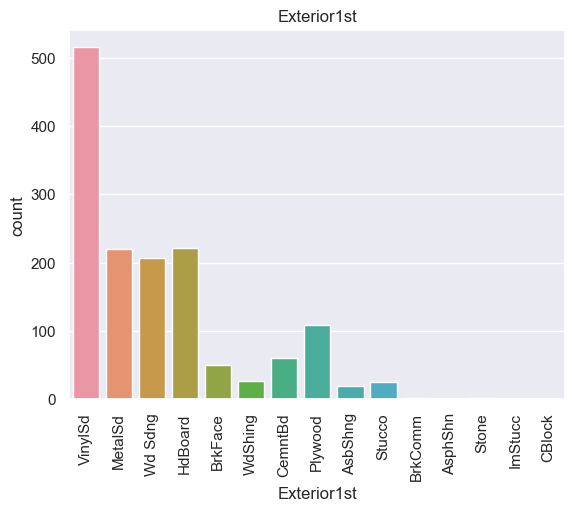

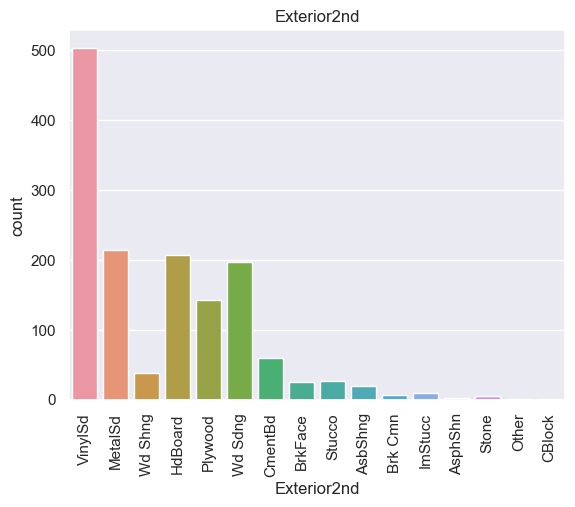

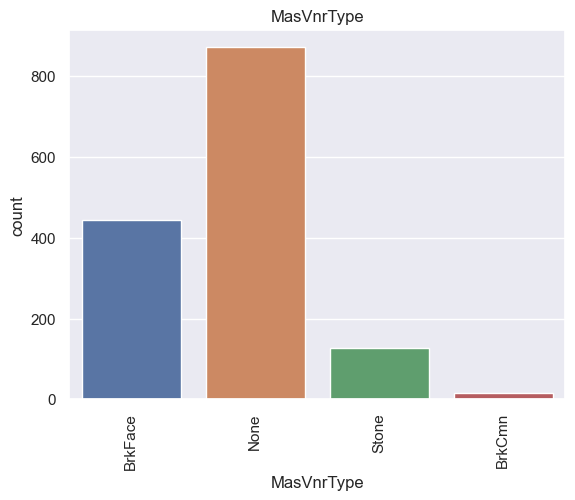

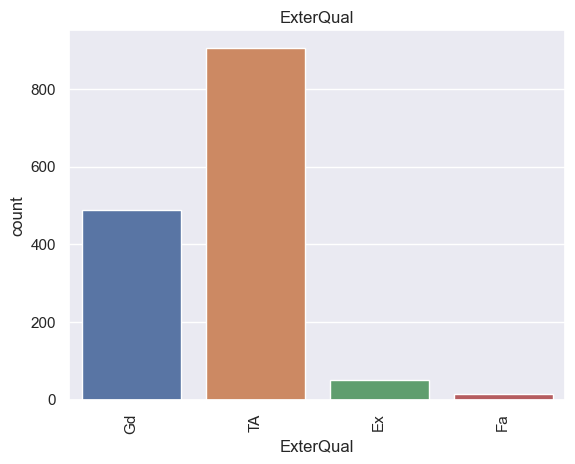

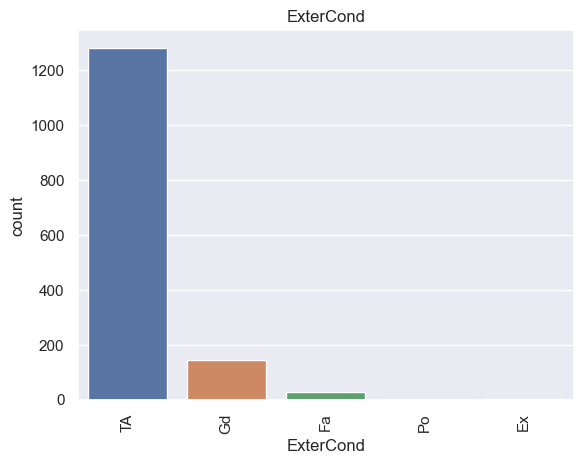

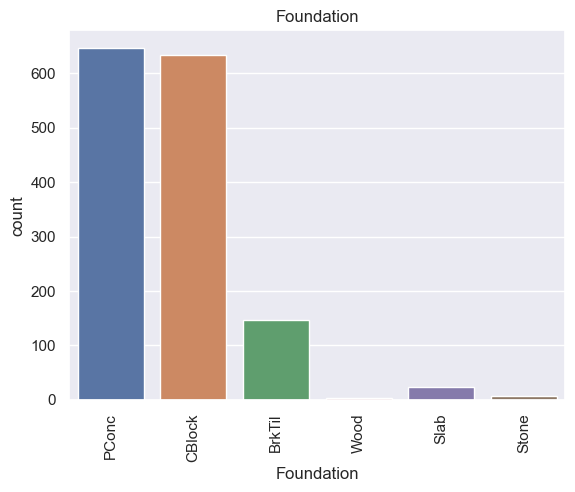

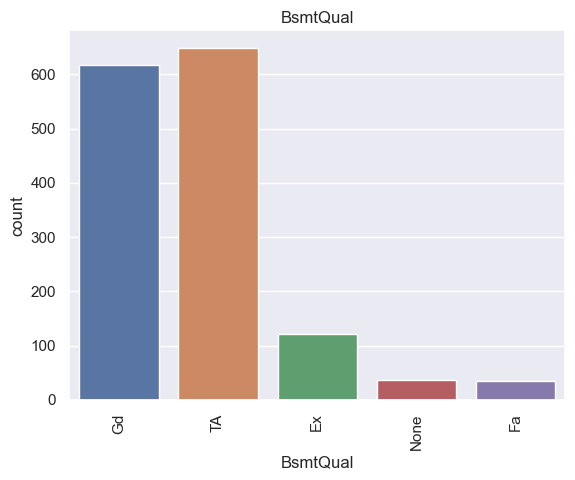

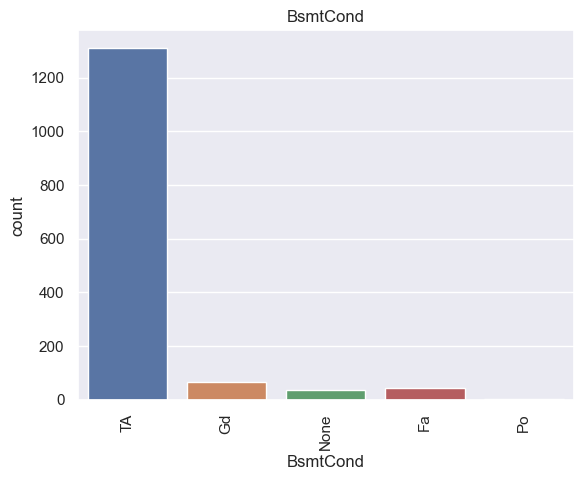

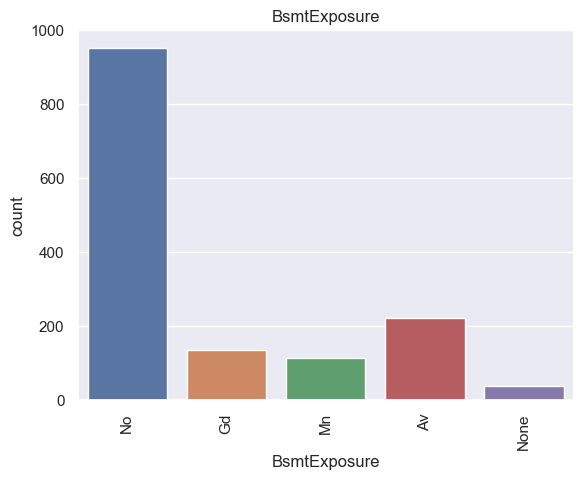

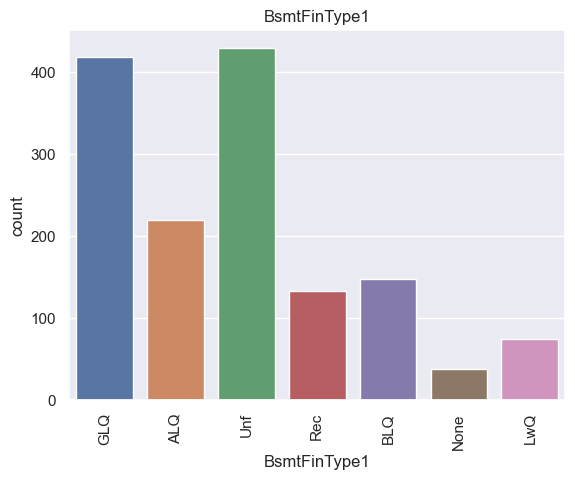

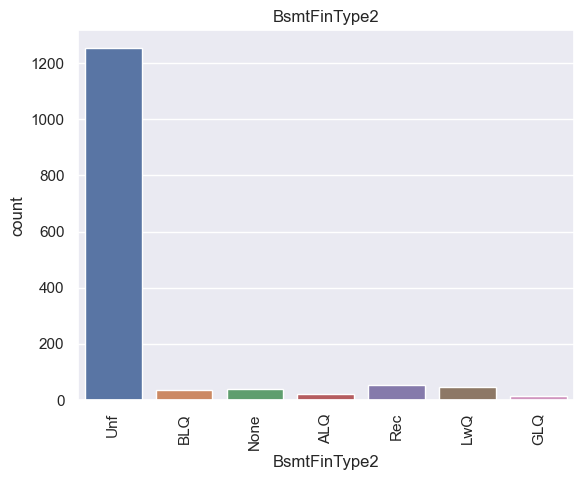

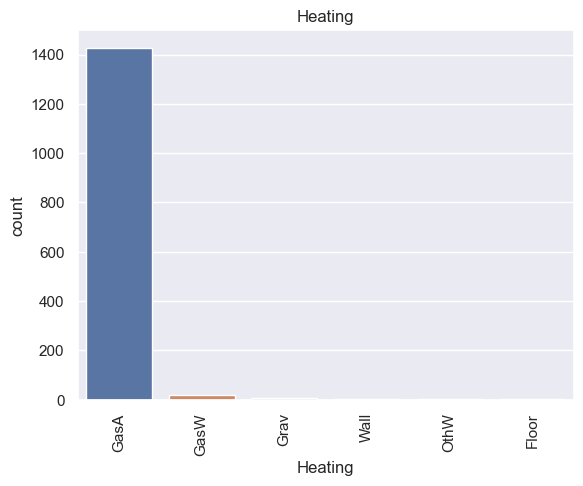

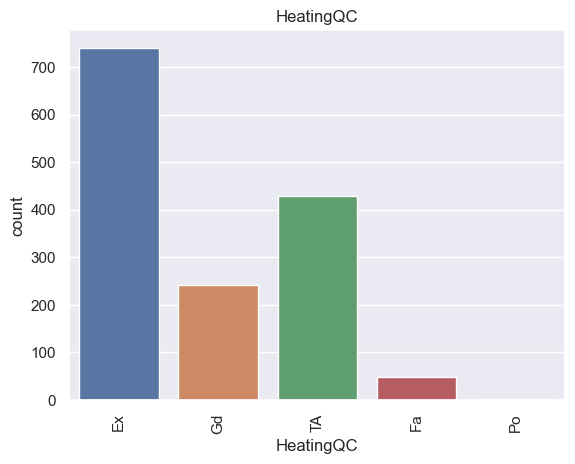

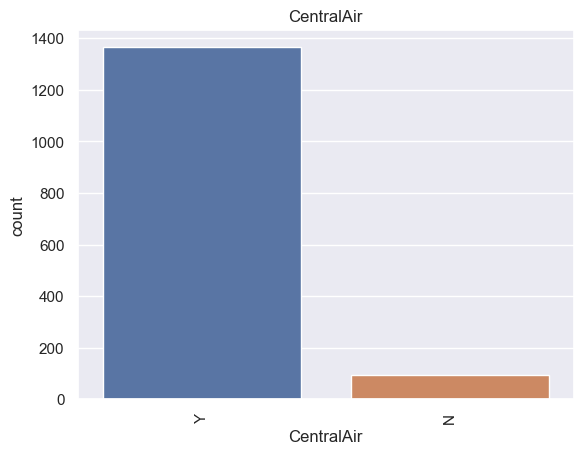

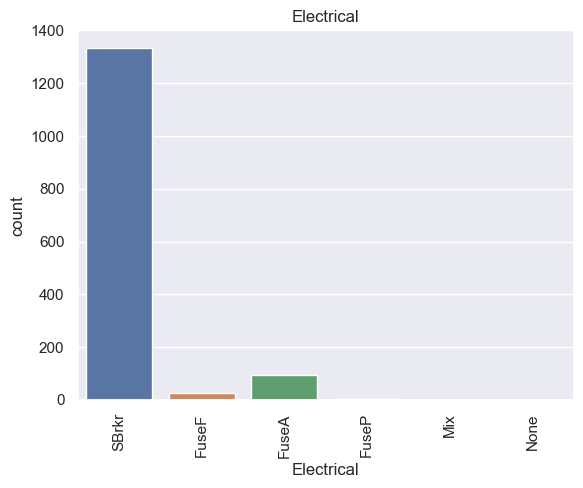

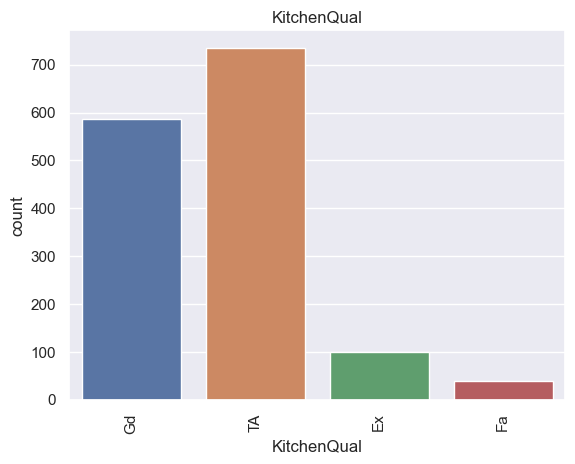

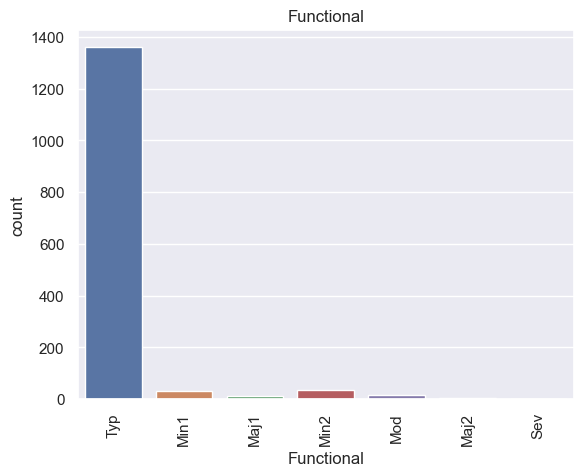

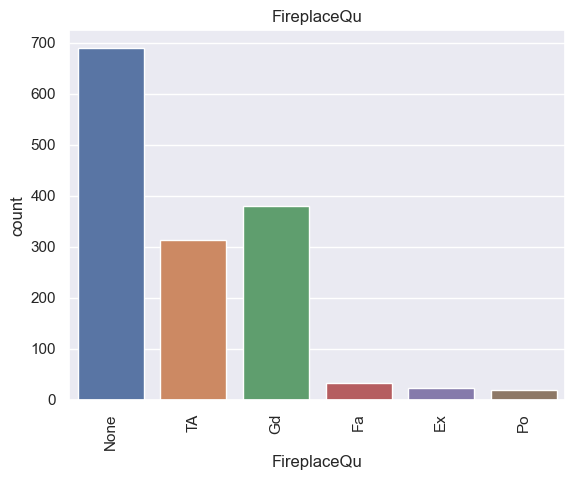

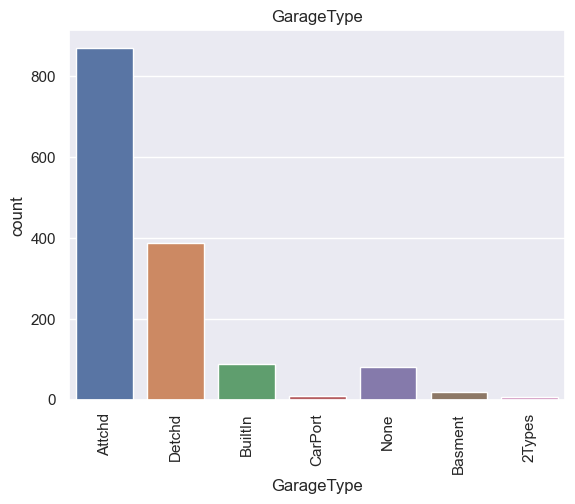

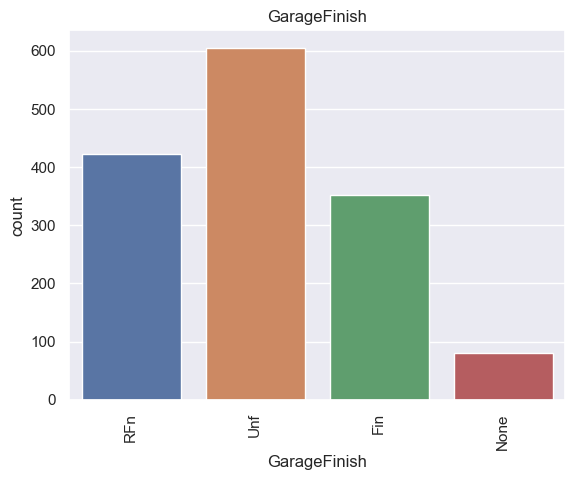

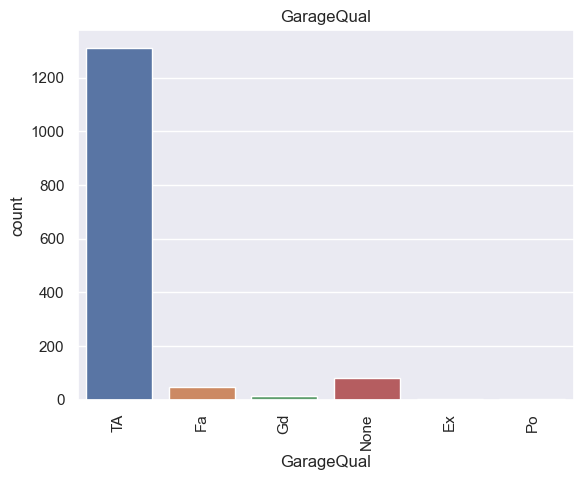

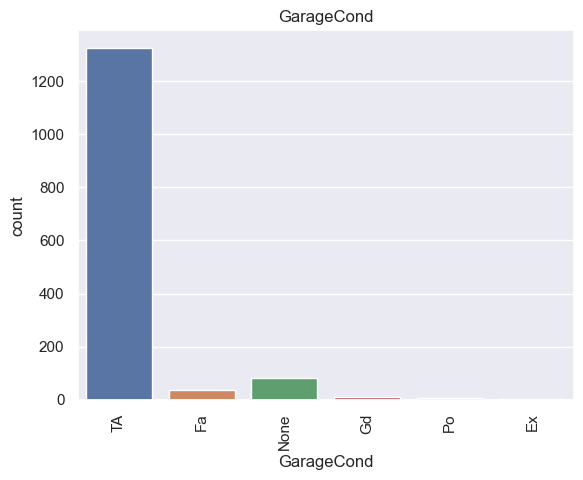

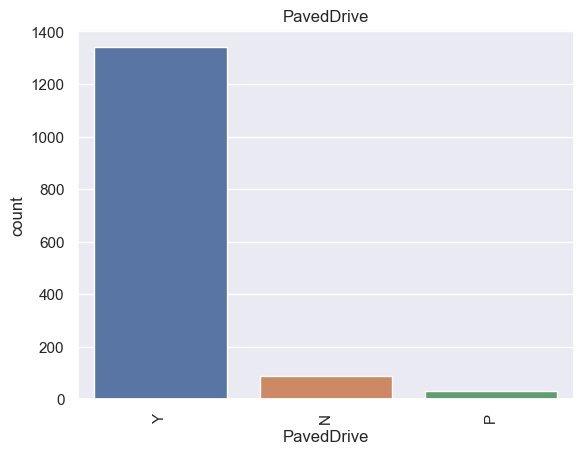

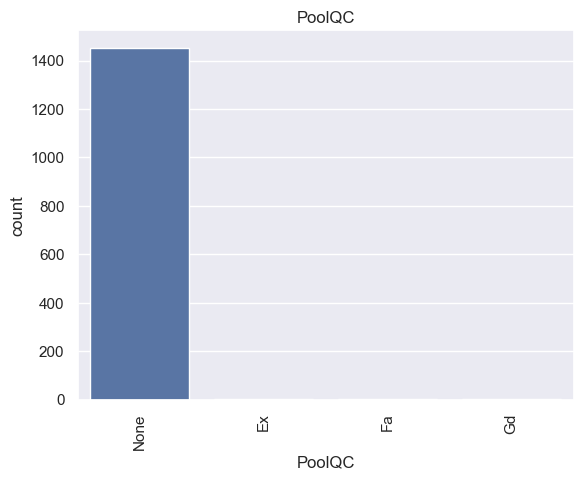

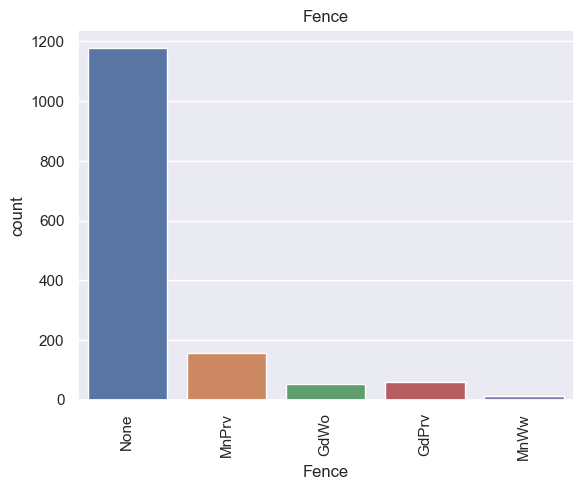

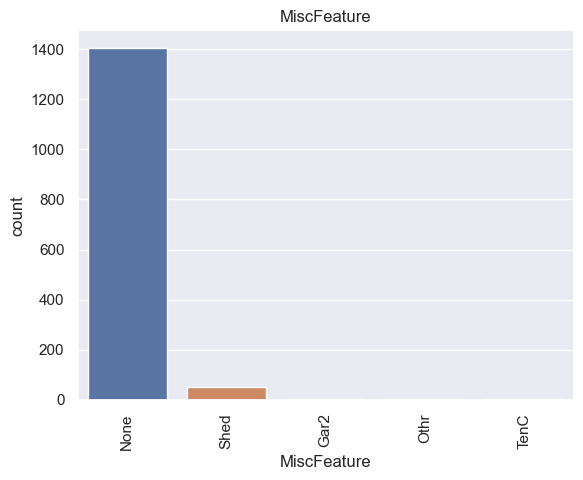

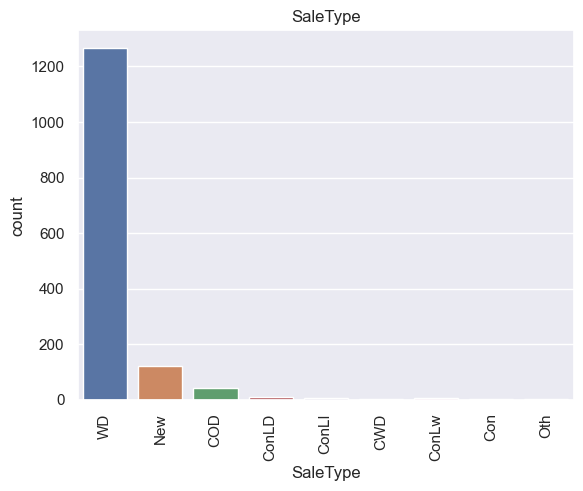

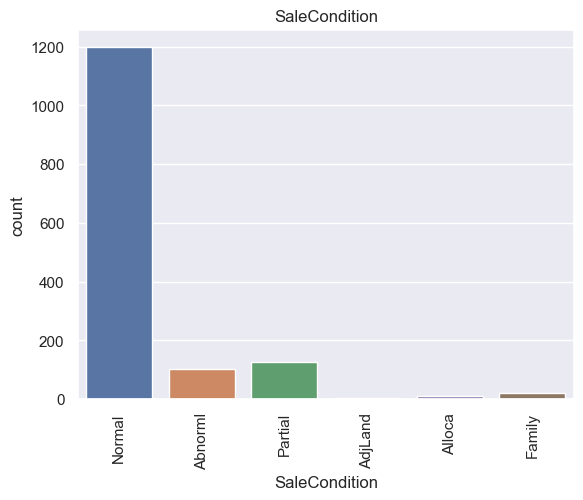

In [37]:
# Categorical plots for categorical features
for col in categorical_features:
    sns.countplot(data=train_data, x=col)
    plt.xticks(rotation=90)
    plt.title(col)
    plt.show()

In [38]:
def tabulate(series: pd.Series, cond: pd.Series = None, dropna: bool = False) -> pd.DataFrame:
    # Returns DataFrame containing the values counts (freq) of values in the series
    if cond is not None:
        series = series[cond]
    table = pd.DataFrame(
        [series.value_counts(dropna=dropna),
        round(series.value_counts(normalize=True, dropna=dropna) * 100, 2)],
        index=['N', '%']).swapaxes('index', 'columns')
    return table

In [39]:
cat_features_counts = {}
for col in categorical_features:
    print(col)
    print(tabulate(train_data[col]))
    print("\n")

MSSubClass
         N      %
20   536.0  36.71
60   299.0  20.48
50   144.0   9.86
120   87.0   5.96
30    69.0   4.73
160   63.0   4.32
70    60.0   4.11
80    58.0   3.97
90    52.0   3.56
190   30.0   2.05
85    20.0   1.37
75    16.0   1.10
45    12.0   0.82
180   10.0   0.68
40     4.0   0.27


MSZoning
              N      %
RL       1151.0  78.84
RM        218.0  14.93
FV         65.0   4.45
RH         16.0   1.10
C (all)    10.0   0.68


Street
           N      %
Pave  1454.0  99.59
Grvl     6.0   0.41


Alley
           N      %
None  1369.0  93.77
Grvl    50.0   3.42
Pave    41.0   2.81


LotShape
         N      %
Reg  925.0  63.36
IR1  484.0  33.15
IR2   41.0   2.81
IR3   10.0   0.68


LandContour
          N      %
Lvl  1311.0  89.79
Bnk    63.0   4.32
HLS    50.0   3.42
Low    36.0   2.47


Utilities
             N      %
AllPub  1459.0  99.93
NoSeWa     1.0   0.07


LotConfig
              N      %
Inside   1052.0  72.05
Corner    263.0  18.01
CulDSac    94.0   6.44
FR2

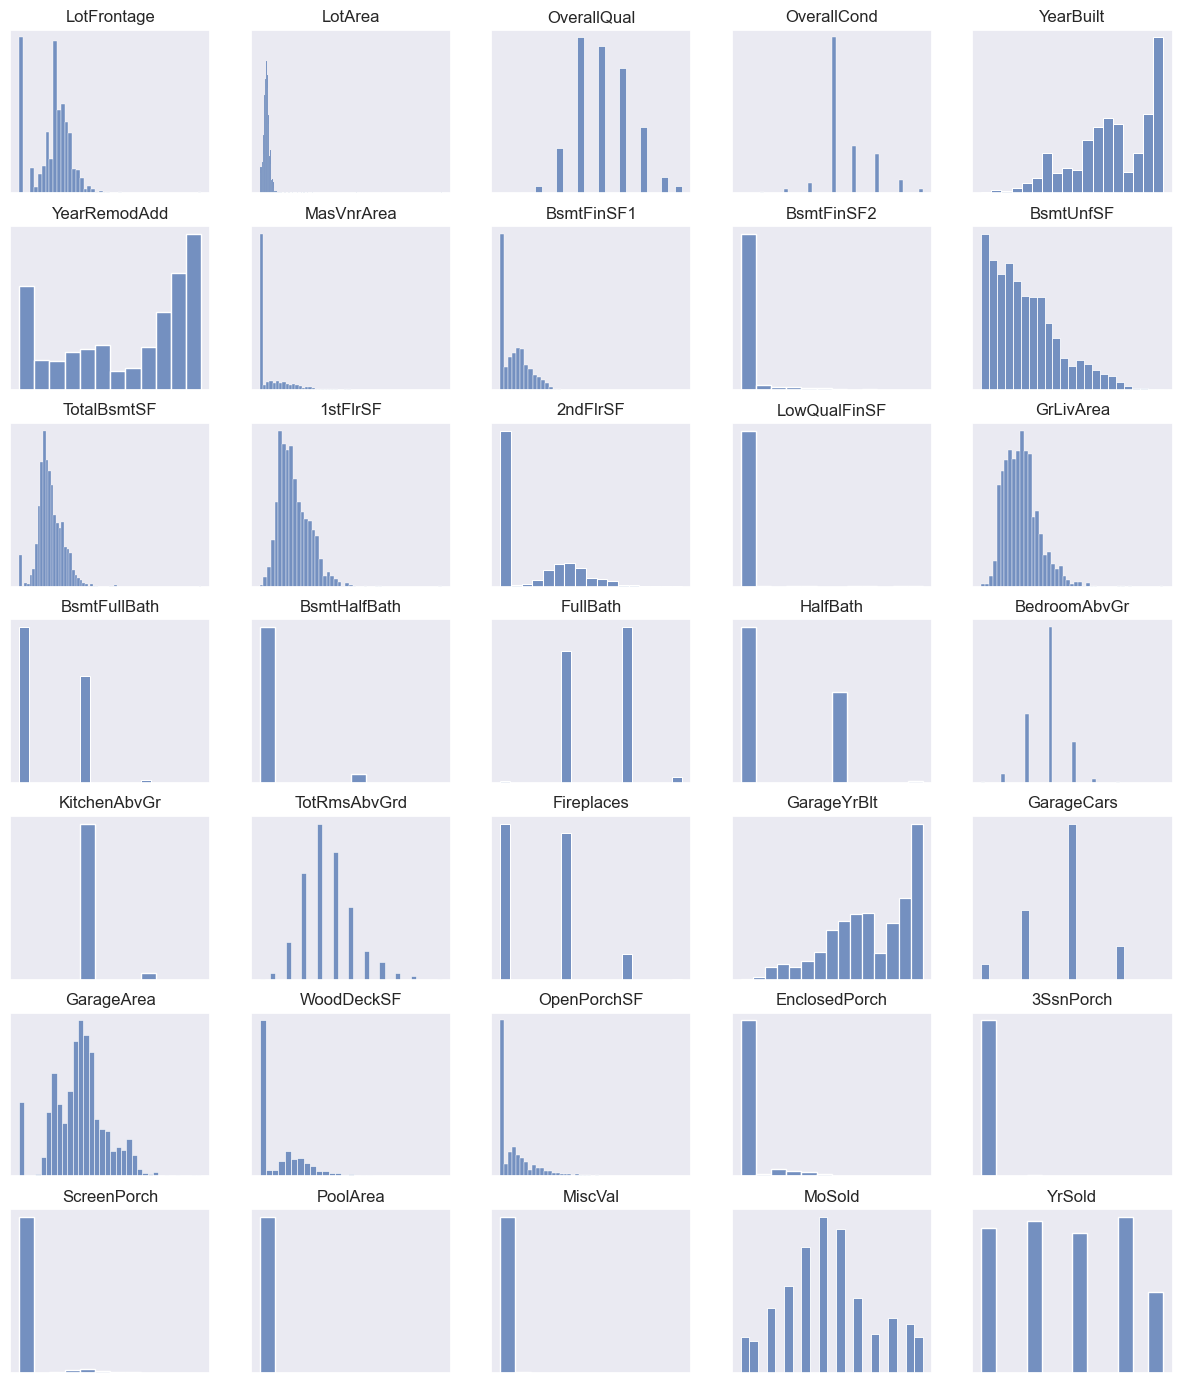

In [40]:
# Plot histograms for continuous features
plt.figure(figsize=(15, 20))
i = 0
for col in continuous_features:
    plt.subplot(8, 5, i+1)
    sns.histplot(data=train_data, x=col)
    plt.title(col)
    # Don't show axis ticks or tick labels.
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    i += 1

In [41]:
train_data[continuous_features].describe().T

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1460.0,57.623288,34.664304,0.0,42.00,63.0,79.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1460.0,103.117123,180.731373,0.0,0.00,0.0,164.25,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0


In [42]:
train_data["LowQualFinSF"].value_counts()

0      1434
80        3
360       2
205       1
479       1
397       1
514       1
120       1
481       1
232       1
53        1
515       1
156       1
473       1
420       1
390       1
371       1
392       1
144       1
572       1
528       1
234       1
513       1
384       1
Name: LowQualFinSF, dtype: int64

In [43]:
train_data["3SsnPorch"].value_counts()

0      1436
168       3
144       2
180       2
216       2
290       1
153       1
96        1
23        1
162       1
182       1
196       1
320       1
245       1
238       1
508       1
140       1
130       1
407       1
304       1
Name: 3SsnPorch, dtype: int64

In [44]:
train_data["PoolArea"].value_counts()

0      1453
512       1
648       1
576       1
555       1
480       1
519       1
738       1
Name: PoolArea, dtype: int64

In [45]:
train_data["MiscVal"].value_counts()

0        1408
400        11
500         8
700         5
450         4
600         4
2000        4
1200        2
480         2
15500       1
800         1
350         1
3500        1
1300        1
54          1
620         1
560         1
1400        1
8300        1
1150        1
2500        1
Name: MiscVal, dtype: int64

## 4.	Compute and order the features by their correlation with label
- Using Spearman correlation rather than pearson correlation due to skewed distributions of the features
- Five highest positive spearman correlations between sale price and features include: OverallQual, GrLivArea, GarageCars, YearBuilt and GarageArea

In [46]:
corr_with_target = train_data.corr("spearman")["SalePrice"].to_frame().sort_values("SalePrice", ascending=False)
corr_with_target = corr_with_target.drop(index="SalePrice")
corr_with_target

,SalePrice
OverallQual,0.809829
GrLivArea,0.731310
GarageCars,0.690711
YearBuilt,0.652682
GarageArea,0.649379
FullBath,0.635957
TotalBsmtSF,0.602725
GarageYrBlt,0.593788
1stFlrSF,0.575408
YearRemodAdd,0.571159


## 5.	Add more EDA that will help you understand the data and support your modeling decisions

Continuous Feature Correlations

In [47]:
corr = train_data[continuous_features].corr("spearman")
corr

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
LotFrontage,1.000000,0.340752,0.190074,-0.072094,0.131273,0.128500,0.139899,0.037291,-0.004078,0.153897,...,0.261886,0.029778,0.106715,-0.041061,0.025087,0.027541,0.062583,-0.022245,0.034712,-0.011997
LotArea,0.340752,1.000000,0.233303,-0.046912,0.103385,0.075158,0.175909,0.171995,0.072019,0.077830,...,0.367153,0.184285,0.176965,-0.066563,0.062282,0.092316,0.084460,0.059297,0.006423,-0.027473
OverallQual,0.190074,0.233303,1.000000,-0.177521,0.647392,0.557723,0.408136,0.132957,-0.117560,0.272939,...,0.541552,0.259439,0.435046,-0.162434,0.032903,0.046335,0.056667,-0.088019,0.061455,-0.025464
OverallCond,-0.072094,-0.046912,-0.177521,1.000000,-0.416964,-0.041464,-0.175895,-0.011087,0.102471,-0.128270,...,-0.200718,-0.042662,-0.133284,0.109749,0.032384,0.074728,-0.005605,0.086625,-0.007203,0.050214
YearBuilt,0.131273,0.103385,0.647392,-0.416964,1.000000,0.684388,0.395589,0.189645,-0.111692,0.139014,...,0.528281,0.287729,0.392691,-0.408622,0.022498,-0.073119,0.008986,-0.091786,0.018621,-0.014100
YearRemodAdd,0.128500,0.075158,0.557723,-0.041464,0.684388,1.000000,0.229194,0.063353,-0.126086,0.176921,...,0.398267,0.230241,0.353325,-0.235037,0.051694,-0.045808,0.002821,-0.090868,0.021081,0.045158
MasVnrArea,0.139899,0.175909,0.408136,-0.175895,0.395589,0.229194,1.000000,0.237541,-0.059622,0.074779,...,0.360858,0.174173,0.204573,-0.178764,0.041525,0.039308,0.005148,-0.049343,0.016964,0.000322
BsmtFinSF1,0.037291,0.171995,0.132957,-0.011087,0.189645,0.063353,0.237541,1.000000,0.050398,-0.573638,...,0.244161,0.179359,0.081420,-0.148339,0.046802,0.071989,0.057586,0.005097,-0.016405,0.020793
BsmtFinSF2,-0.004078,0.072019,-0.117560,0.102471,-0.111692,-0.126086,-0.059622,0.050398,1.000000,-0.271007,...,-0.007295,0.069343,-0.068991,0.041524,-0.016079,0.058716,0.068076,0.030363,-0.025808,0.026054
BsmtUnfSF,0.153897,0.077830,0.272939,-0.128270,0.139014,0.176921,0.074779,-0.573638,-0.271007,1.000000,...,0.109167,-0.034866,0.156127,0.044242,0.013418,-0.012447,-0.036809,-0.044460,0.037116,-0.038552


C:\Users\kherz\AppData\Local\Temp\ipykernel_4964\758609148.py:2: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



<AxesSubplot:>

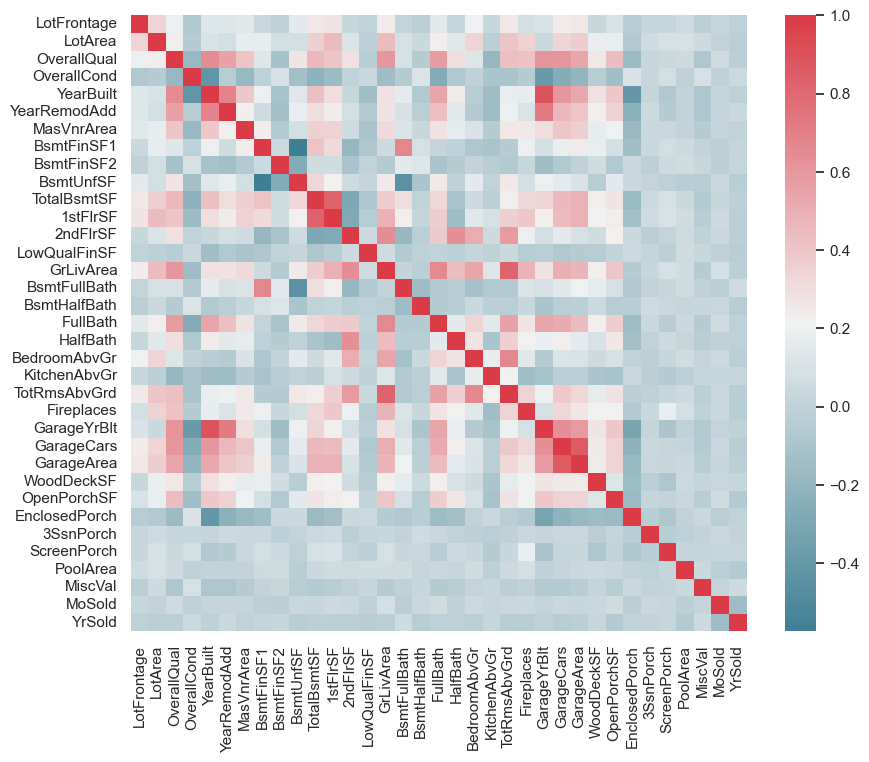

In [48]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [49]:
# Obtain list of correlated features (where correlation > corre_threshold)
corr_threshold = 0.80
correlated_features = set()

feature_xcorr = corr

# Sort continuous features by correlation with target so that we always drop features less correlated with the target.
cont_features_sorted_corr_with_target = corr_with_target.loc[continuous_features, "SalePrice"].sort_values(ascending=False).index

for col in cont_features_sorted_corr_with_target:
   if col in correlated_features:
      continue

   col_correlations = feature_xcorr[col]
   highly_correlated_feature = col_correlations.index[col_correlations.abs() > corr_threshold].to_list()
   highly_correlated_feature.remove(col)

   correlated_features = correlated_features.union(set(highly_correlated_feature))

uncorrelated_features = continuous_features[~continuous_features.isin(correlated_features)]

In [50]:
# Test that there are no longer correlated features.
abs_corr_uncorr_features = train_data[uncorrelated_features].corr().abs()
((abs_corr_uncorr_features > corr_threshold) & (abs_corr_uncorr_features != 1.0)).any().any()

False

In [51]:
correlated_features

{'1stFlrSF', 'GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd'}

In [52]:
corr["1stFlrSF"].sort_values(ascending=False)[0:5]

1stFlrSF       1.000000
TotalBsmtSF    0.829292
GrLivArea      0.494421
GarageArea     0.489797
GarageCars     0.450580
Name: 1stFlrSF, dtype: float64

In [53]:
corr["GarageArea"].sort_values(ascending=False)[0:5]

GarageArea     1.000000
GarageCars     0.853317
GarageYrBlt    0.591889
OverallQual    0.541552
YearBuilt      0.528281
Name: GarageArea, dtype: float64

In [54]:
corr["GarageYrBlt"].sort_values(ascending=False)[0:5]

GarageYrBlt     1.000000
YearBuilt       0.890546
YearRemodAdd    0.722377
GarageCars      0.630966
OverallQual     0.618193
Name: GarageYrBlt, dtype: float64

In [55]:
corr["TotRmsAbvGrd"].sort_values(ascending=False)[0:5]

TotRmsAbvGrd    1.000000
GrLivArea       0.827874
BedroomAbvGr    0.667822
2ndFlrSF        0.587189
FullBath        0.558665
Name: TotRmsAbvGrd, dtype: float64

In [56]:
uncorrelated_features

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'Fireplaces', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

## Feature Selection
-	Combine MoSold and YrSold into DateSold
    - Compute continuous variable in months to represent date sold

- Remove correlated continuous features
    - 1stFlrSF
    - GarageArea
    - GarageYrBlt
    - TotRmsAbvGrd

-	Remove categorical features with > 99% of data in only category: 
    -   Street (pave: 99.59%, gravel: 0.41%)
    -   Utilities (AllPub: 99.93%, NoSeWa 0.07%)

-	Recategorize features into binary form for features with one category having >= 97% of the data and other categories having the remaining 3% of data: 
    -   Condition2 (Norm (98.97%) vs. all Other)
    -   RoofMatl (CompShg (98.22%) vs. Other)
    -   Heating (GasA (97.81%) vs. Other)
    -   LowQualFinSF (0 vs. >=1)
    -   3SsnPorch (0 vs. >=1)
    -   PoolArea (0 vs. >=1)
    -   MiscVal (0 vs. >=1)


In [57]:
features_selected = train_data[all_features].copy()

### Remove correlated continuous features

In [58]:
features_selected.drop(columns=correlated_features, inplace=True)

### Combine MoSold and YrSold into DateSold

In [59]:
features_selected["DateSold"] = pd.to_datetime(features_selected['MoSold'].astype(str) + '/' + features_selected['YrSold'].astype(str), format="%m/%Y")

In [60]:
def get_month_after_Jan2000(dt, start_year = 2000):
    return (dt.year - start_year) * 12 + dt.month

In [61]:
features_selected["MonthNumSold"] = features_selected["DateSold"].apply(get_month_after_Jan2000)

In [62]:
features_selected.drop(columns=["MoSold", "YrSold", "DateSold"], inplace=True)

### Remove categorical features with > 99% of data in only category:
- Street (pave: 99.59%, gravel: 0.41%)
- Utilities (AllPub: 99.93%, NoSeWa 0.07%)

In [63]:
features_selected.drop(columns=["Street", "Utilities"], inplace=True)

### Recategorize features into binary form for features with one category having 97% of the data and other categories have remaining 3% of data: 
- Condition2 (Norm (98.97%) vs. all Other)
- RoofMatl (CompShg (98.22%) vs. Other)
- Heating (GasA (97.81%) vs. Other)
- LowQualFinSF (0 vs. >=1)
- 3SsnPorch (0 vs. >=1)
- PoolArea (0 vs. >=1)
- MiscVal (0 vs. >=1)

In [64]:
features_selected["Condition2_recategorized"] = np.nan  # (Norm (98.97%) vs. Other)
features_selected.loc[(features_selected['Condition2'] == "Norm"), 'Condition2_recategorized'] = 'Norm'
features_selected.loc[~(features_selected['Condition2'] == "Norm"), 'Condition2_recategorized'] = 'Other'


In [65]:
features_selected["RoofMatl_recategorized"] = np.nan  # RoofMatl (CompShg (98.22%) vs. Other)
features_selected.loc[(features_selected['RoofMatl'] == "CompShg"), 'RoofMatl_recategorized'] = 'CompShg'
features_selected.loc[~(features_selected['RoofMatl'] == "CompShg"), 'RoofMatl_recategorized'] = 'Other'

In [66]:
features_selected["Heating_recategorized"] = np.nan  # Heating (GasA (97.81%) vs. Other)
features_selected.loc[(features_selected['Heating'] == "GasA"), 'Heating_recategorized'] = 'GasA'
features_selected.loc[~(features_selected['Heating'] == "GasA"), 'Heating_recategorized'] = 'Other'

In [67]:
# Change some categorical features to boolean.
cat2bool_cols = ["LowQualFinSF", "3SsnPorch", "PoolArea", "MiscVal"]
for col in cat2bool_cols:
    features_selected[f"{col}_recategorized"] = 0
    features_selected.loc[features_selected[col] > 0, f"{col}_recategorized"] = 1

In [68]:
features_selected.drop(columns=["Condition2", "RoofMatl", "Heating", "LowQualFinSF", "3SsnPorch", "PoolArea", "MiscVal"], inplace=True)

In [69]:
# View remaining columns
features_selected.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       'CentralAir', 'Electrical', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MonthNumSold',
   